# Tutorial: Introductory Tutorial: A Beginner’s Guide to PINA

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mathLab/PINA/blob/master/tutorials/tutorial17/tutorial.ipynb)

<p align="left">
    <img src="https://raw.githubusercontent.com/mathLab/PINA/master/readme/pina_logo.png" alt="PINA logo" width="90"/>
</p>


Welcome to **PINA**!

PINA [1] is an open-source Python library designed for **Scientific Machine Learning (SciML)** tasks, particularly involving:

- **Physics-Informed Neural Networks (PINNs)**
- **Neural Operators (NOs)**
- **Reduced Order Models (ROMs)**
- **Graph Neural Networks (GNNs)**
- ...

Built on **PyTorch**, **PyTorch Lightning**, and **PyTorch Geometric**, it provides a **user-friendly, intuitive interface** for formulating and solving differential problems using neural networks.

This tutorial offers a **step-by-step guide** to using PINA—starting from basic to advanced techniques—enabling users to tackle a broad spectrum of differential problems with minimal code.




## The PINA Workflow 

<p align="center">
    <img src="http://raw.githubusercontent.com/mathLab/PINA/master/tutorials/static/pina_workflow.png" alt="PINA Workflow" width="1000"/>
</p>

Solving a differential problem in **PINA** involves four main steps:

1. ***Problem & Data***
   Define the mathematical problem and its physical constraints using PINA’s base classes:  
   - `AbstractProblem`
   - `SpatialProblem`
   - `InverseProblem`  
   - ...

   Then prepare inputs by discretizing the domain or importing numerical data. PINA provides essential tools like the `Conditions` class and the `pina.domain` module to facilitate domain sampling and ensure that the input data aligns with the problem's requirements.

> **👉 We have a dedicated [tutorial](https://mathlab.github.io/PINA/tutorial16/tutorial.html) to teach how to build a Problem from scratch — have a look if you're interested!**

2. ***Model Design***  
   Build neural network models as **PyTorch modules**. For graph-structured data, use **PyTorch Geometric** to build Graph Neural Networks. You can also import models from `pina.model` module!

3. ***Solver Selection***  
   Choose and configure a solver to optimize your model. Options include:
   - **Supervised solvers**: `SupervisedSolver`, `ReducedOrderModelSolver`
   - **Physics-informed solvers**: `PINN` and (many) variants
   - **Generative solvers**: `GAROM`  
   Solvers can be used out-of-the-box, extended, or fully customized.

4. ***Training***  
   Train your model using the `Trainer` class (built on **PyTorch Lightning**), which enables scalable and efficient training with advanced features.


By following these steps, PINA simplifies applying deep learning to scientific computing and differential problems.


## A Simple Regression Problem in PINA
We'll start with a simple regression problem [2] of approximating the following function with a Neural Net model $\mathcal{M}_{\theta}$:
$$y = x^3 + \epsilon, \quad \epsilon \sim \mathcal{N}(0, 9)$$  
using only 20 samples:  

$$x_i \sim \mathcal{U}[-3, 3], \; \forall i \in \{1, \dots, 20\}$$

Using PINA, we will:

- Generate a synthetic dataset.
- Implement a **Bayesian regressor**.
- Use **Monte Carlo (MC) Dropout** for **Bayesian inference** and **uncertainty estimation**.

This example highlights how PINA can be used for classic regression tasks with probabilistic modeling capabilities. Let's first import useful modules!

In [1]:
## routine needed to run the notebook on Google Colab
try:
    import google.colab

    IN_COLAB = True
except:
    IN_COLAB = False
if IN_COLAB:
    !pip install "pina-mathlab[tutorial]"

import warnings
import torch
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

from pina import Condition, LabelTensor
from pina.problem import AbstractProblem
from pina.domain import EllipsoidDomain, Difference, CartesianDomain, Union

#### ***Problem & Data***

We'll start by defining a `BayesianProblem` inheriting from `AbstractProblem` to handle input/output data. This is suitable when data is available. For other cases like PDEs without data, use:

- `SpatialProblem` – for spatial variables
- `TimeDependentProblem` – for temporal variables
- `ParametricProblem` – for parametric inputs
- `InverseProblem` – for parameter estimation from observations
 
but we will see this more in depth in a while!

In [2]:
# (a) Data generation and plot
domain = CartesianDomain({"x": [-3, 3]})
x = domain.sample(n=20, mode="random")
y = LabelTensor(x.pow(3) + 3 * torch.randn_like(x), "y")


# (b) PINA Problem formulation
class BayesianProblem(AbstractProblem):

    output_variables = ["y"]
    input_variables = ["x"]
    conditions = {"data": Condition(input=x, target=y)}


problem = BayesianProblem()

# # (b) EXTRA!
# # alternatively you can do the following which is easier
# # uncomment to try it!
# from pina.problem.zoo import SupervisedProblem
# problem = SupervisedProblem(input_=x, output_=y)

We highlight two very important features of PINA

1. **`LabelTensor` Structure**  
   - Alongside the standard `torch.Tensor`, PINA introduces the `LabelTensor` structure, which allows **string-based indexing**.  
   - Ideal for managing and stacking tensors with different labels (e.g., `"x"`, `"t"`, `"u"`) for improved clarity and organization.  
   - You can still use standard PyTorch tensors if needed.

2. **`Condition` Object**  
   - The `Condition` object enforces the **constraints** that the model $\mathcal{M}_{\theta}$ must satisfy, such as boundary or initial conditions.  
   - It ensures that the model adheres to the specific requirements of the problem, making constraint handling more intuitive and streamlined.

In [3]:
# EXTRA - on the use of LabelTensor

# We define a 2D tensor, and we index with ['a', 'b', 'c', 'd'] its columns
label_tensor = LabelTensor(torch.rand(3, 4), ["a", "b", "c", "d"])

print(f"The Label Tensor object, a very short introduction... \n")
print(label_tensor, "\n")
print(f"Torch methods can be used, {label_tensor.shape=}")
print(f"also {label_tensor.requires_grad=} \n")
print(f"But we have labels as well, e.g. {label_tensor.labels=}")
print(f'And we can slice with labels: \n {label_tensor["a"]=}')
print(f"Similarly to: \n {label_tensor[:, 0]=}")

The Label Tensor object, a very short introduction... 

1: {'dof': ['a', 'b', 'c', 'd'], 'name': 1}

tensor([[0.2163, 0.0144, 0.3647, 0.8604],
        [0.8573, 0.9205, 0.2439, 0.6634],
        [0.0080, 0.8176, 0.9072, 0.5077]]) 

Torch methods can be used, label_tensor.shape=torch.Size([3, 4])
also label_tensor.requires_grad=False 

But we have labels as well, e.g. label_tensor.labels=['a', 'b', 'c', 'd']
And we can slice with labels: 
 label_tensor["a"]=LabelTensor([[0.2163],
             [0.8573],
             [0.0080]])
Similarly to: 
 label_tensor[:, 0]=LabelTensor([[0.2163],
             [0.8573],
             [0.0080]])


#### ***Model Design***

We will now solve the problem using a **simple PyTorch Neural Network** with **Dropout**, which we will implement from scratch following [2].  
It's important to note that PINA provides a wide range of **state-of-the-art (SOTA)** architectures in the `pina.model` module, which you can explore further [here](https://mathlab.github.io/PINA/_rst/_code.html#models).

#### ***Solver Selection***

For this task, we will use a straightforward **supervised learning** approach by importing the `SupervisedSolver` from `pina.solvers`. The solver is responsible for defining the training strategy.  

The `SupervisedSolver` is designed to handle typical regression tasks effectively by minimizing the following loss function:
$$
\mathcal{L}_{\rm{problem}} = \frac{1}{N}\sum_{i=1}^N
\mathcal{L}(y_i - \mathcal{M}_{\theta}(x_i))
$$
where $\mathcal{L}$ is the loss function, with the default being **Mean Squared Error (MSE)**:
$$
\mathcal{L}(v) = \| v \|^2_2.
$$

#### **Training**

Next, we will use the `Trainer` class to train the model. The `Trainer` class, based on **PyTorch Lightning**, offers many features that help:
- **Improve model accuracy**
- **Reduce training time and memory usage**
- **Facilitate logging and visualization**  

The great work done by the PyTorch Lightning team ensures a streamlined training process.

In [4]:
from pina.solver import SupervisedSolver
from pina.trainer import Trainer


# define problem & data (step 1)
class BayesianModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(1, 100),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(100, 1),
        )

    def forward(self, x):
        return self.layers(x)


problem = BayesianProblem()

# model design (step 2)
model = BayesianModel()

# solver selection (step 3)
solver = SupervisedSolver(problem, model)

# training (step 4)
trainer = Trainer(solver=solver, max_epochs=2000, accelerator="cpu")
trainer.train()

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/u/g/gcanali/miniconda3/envs/deep/lib/python3.12/site-packages/lightning/pytorch/trainer/setup.py: PossibleUserWarning: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/scratch/gcanali/PINA/pina/trainer.py: UserWarning: Compilation is disabled for Python 3.14+ and for Windows.
/u/g/gcanali/miniconda3/envs/deep/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name         | Type       | Params | Mode 
----------------------------------------------------
0 | _pina_models | ModuleList | 301    | train

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=2000` reached.


#### ***Model Training Complete! Now Visualize the Solutions***

The model has been trained! Since we used **Dropout** during training, the model is probabilistic (Bayesian) [3]. This means that each time we evaluate the forward pass on the input points $x_i$, the results will differ due to the stochastic nature of Dropout.

To visualize the model's predictions and uncertainty, we will:

1. **Evaluate the Forward Pass**: Perform multiple forward passes to get different predictions for each input $x_i$.
2. **Compute the Mean**: Calculate the average prediction $\mu_\theta$ across all forward passes.
3. **Compute the Standard Deviation**: Calculate the variability of the predictions $\sigma_\theta$, which indicates the model's uncertainty.

This allows us to understand not only the predicted values but also the confidence in those predictions.

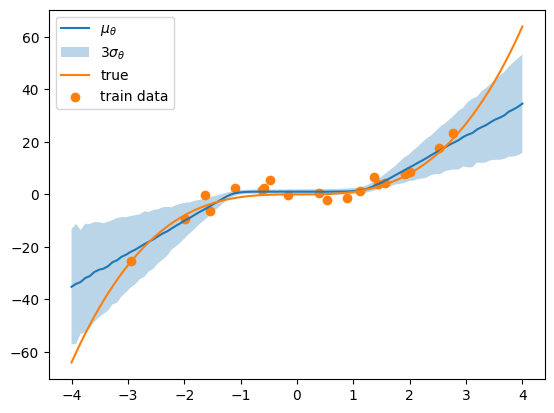

In [5]:
x_test = LabelTensor(torch.linspace(-4, 4, 100).reshape(-1, 1), "x")
y_test = torch.stack([solver(x_test) for _ in range(1000)], dim=0)
y_mean, y_std = y_test.mean(0).detach(), y_test.std(0).detach()
# plot
x_test = x_test.flatten()
y_mean = y_mean.flatten()
y_std = y_std.flatten()
plt.plot(x_test, y_mean, label=r"$\mu_{\theta}$")
plt.fill_between(
    x_test,
    y_mean - 3 * y_std,
    y_mean + 3 * y_std,
    alpha=0.3,
    label=r"3$\sigma_{\theta}$",
)
plt.plot(x_test, x_test.pow(3), label="true")
plt.scatter(x, y, label="train data")
plt.legend()
plt.show()

## PINA for Physics-Informed Machine Learning

In the previous section, we used PINA for **supervised learning**. However, one of its main strengths lies in **Physics-Informed Machine Learning (PIML)**, specifically through **Physics-Informed Neural Networks (PINNs)**.

### What Are PINNs?

PINNs are deep learning models that integrate the laws of physics directly into the training process. By incorporating **differential equations** and **boundary conditions** into the loss function, PINNs allow the modeling of complex physical systems while ensuring the predictions remain consistent with scientific laws.

### Solving a 2D Poisson Problem

In this section, we will solve a **2D Poisson problem** with **Dirichlet boundary conditions** on an **hourglass-shaped domain** using a simple PINN [4]. You can explore other PINN variants, e.g. [5] or [6] in PINA by visiting the [PINA solvers documentation](https://mathlab.github.io/PINA/_rst/_code.html#solvers). We aim to solve the following 2D Poisson problem:

$$
\begin{cases}
\Delta u(x, y) = \sin{(\pi x)} \sin{(\pi y)} & \text{in } D, \\
u(x, y) = 0 & \text{on } \partial D 
\end{cases}
$$

where $D$ is an **hourglass-shaped domain** defined as the difference between a **Cartesian domain** and two intersecting **ellipsoids**, and $\partial D$ is the boundary of the domain.

### Building Complex Domains

PINA allows you to build complex geometries easily. It provides many built-in domain shapes and Boolean operators for combining them. For this problem, we will define the hourglass-shaped domain using the existing `CartesianDomain` and `EllipsoidDomain` classes, with Boolean operators like `Difference` and `Union`.

> **👉 If you are interested in exploring the `domain` module in more detail, check out [this tutorial](https://mathlab.github.io/PINA/_rst/tutorials/tutorial6/tutorial.html).**


In [6]:
# (a) Building the interior of the hourglass-shaped domain
cartesian = CartesianDomain({"x": [-3, 3], "y": [-3, 3]})
ellipsoid_1 = EllipsoidDomain({"x": [-5, -1], "y": [-3, 3]})
ellipsoid_2 = EllipsoidDomain({"x": [1, 5], "y": [-3, 3]})
interior = Difference([cartesian, ellipsoid_1, ellipsoid_2])

# (b) Building the boundary of the hourglass-shaped domain
border_ellipsoid_1 = ellipsoid_1.partial()
border_ellipsoid_2 = ellipsoid_2.partial()
border_1 = CartesianDomain({"x": [-3, 3], "y": 3})
border_2 = CartesianDomain({"x": [-3, 3], "y": -3})
ex_1 = CartesianDomain({"x": [-5, -3], "y": [-3, 3]})
ex_2 = CartesianDomain({"x": [3, 5], "y": [-3, 3]})
border_ells = Union([border_ellipsoid_1, border_ellipsoid_2])
border = Union(
    [
        border_1,
        border_2,
        Difference(
            [Union([border_ellipsoid_1, border_ellipsoid_2]), ex_1, ex_2]
        ),
    ]
)

# (c) Sample the domains
interior_samples = interior.sample(n=1000, mode="random")
border_samples = border.sample(n=1000, mode="random")

#### Plotting the domain

Nice! Now that we have built the domain, let's try to plot it

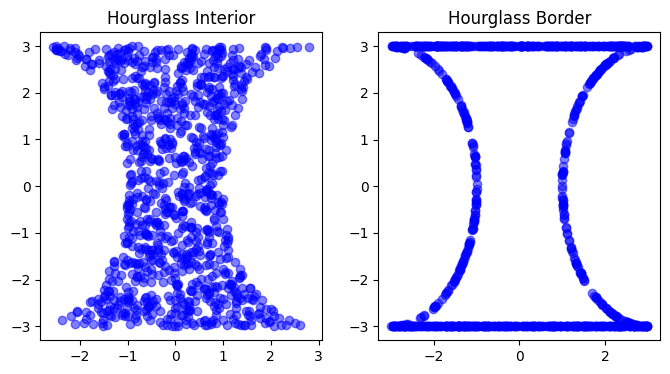

In [7]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.scatter(
    interior_samples.extract("x"),
    interior_samples.extract("y"),
    c="blue",
    alpha=0.5,
)
plt.title("Hourglass Interior")
plt.subplot(1, 2, 2)
plt.scatter(
    border_samples.extract("x"),
    border_samples.extract("y"),
    c="blue",
    alpha=0.5,
)
plt.title("Hourglass Border")
plt.show()

#### Writing the Poisson Problem Class

Very good! Now we will implement the problem class for the 2D Poisson problem. Unlike the previous examples, where we inherited from `AbstractProblem`, for this problem, we will inherit from the `SpatialProblem` class.  

The reason for this is that the Poisson problem involves **spatial variables** as input, so we use `SpatialProblem` to handle such cases.

This will allow us to define the problem with spatial dependencies and set up the neural network model accordingly.

In [8]:
from pina.problem import SpatialProblem
from pina.operator import laplacian
from pina.equation import FixedValue, Equation


def poisson_equation(input_, output_):
    force_term = torch.sin(input_.extract(["x"]) * torch.pi) * torch.sin(
        input_.extract(["y"]) * torch.pi
    )
    laplacian_u = laplacian(output_, input_, components=["u"], d=["x", "y"])
    return laplacian_u - force_term


class Poisson(SpatialProblem):
    # define output_variables and spatial_domain
    output_variables = ["u"]
    spatial_domain = Union([interior, border])
    # define the domains
    domains = {"border": border, "interior": interior}
    # define the conditions
    conditions = {
        "border": Condition(domain="border", equation=FixedValue(0.0)),
        "interior": Condition(
            domain="interior", equation=Equation(poisson_equation)
        ),
    }


poisson_problem = Poisson()

As you can see, writing the problem class for a differential equation in PINA is straightforward! The main differences are:

- We inherit from **`SpatialProblem`** instead of `AbstractProblem` to account for spatial variables.
- We use **`domain`** and **`equation`** inside the `Condition` to define the problem.

The `Equation` class can be very useful for creating modular problem classes. If you're interested, check out [this tutorial](https://mathlab.github.io/PINA/_rst/tutorial12/tutorial.html) for more details. There's also a dedicated [tutorial](https://mathlab.github.io/PINA/_rst/tutorial16/tutorial.html) for building custom problems!

Once the problem class is set, we need to **sample the domain** to obtain the data. PINA will automatically handle this, and if you forget to sample, an error will be raised before training begins 😉.

In [9]:
print("Points are not automatically sampled, you can see this by:")
print(f"    {poisson_problem.are_all_domains_discretised=}\n")
print("But you can easily sample by running .discretise_domain:")
poisson_problem.discretise_domain(n=1000, domains=["interior"])
poisson_problem.discretise_domain(n=100, domains=["border"])
print(f"    {poisson_problem.are_all_domains_discretised=}")

Points are not automatically sampled, you can see this by:
    poisson_problem.are_all_domains_discretised=False

But you can easily sample by running .discretise_domain:
    poisson_problem.are_all_domains_discretised=True


### Building the Model

After setting the problem and sampling the domain, the next step is to **build the model** $\mathcal{M}_{\theta}$.

For this, we will use the custom PINA models available [here](https://mathlab.github.io/PINA/_rst/_code.html#models). Specifically, we will use a **feed-forward neural network** by importing the `FeedForward` class.

This neural network takes the **coordinates** (in this case `['x', 'y']`) as input and outputs the unknown field of the Poisson problem. 

In this tutorial, the neural network is composed of 2 hidden layers, each with 120 neurons and tanh activation.

In [10]:
from pina.model import FeedForward

model = FeedForward(
    func=torch.nn.Tanh,
    layers=[120] * 2,
    output_dimensions=len(poisson_problem.output_variables),
    input_dimensions=len(poisson_problem.input_variables),
)

### Solver Selection

The thir part of the PINA pipeline involves using a **Solver**.

In this tutorial, we will use the **classical PINN** solver. However, many other variants are also available and we invite to try them!

#### Loss Function in PINA

The loss function in the **classical PINN** is defined as follows:

$$\theta_{\rm{best}}=\min_{\theta}\mathcal{L}_{\rm{problem}}(\theta), \quad  \mathcal{L}_{\rm{problem}}(\theta)= \frac{1}{N_{D}}\sum_{i=1}^N
\mathcal{L}(\Delta\mathcal{M}_{\theta}(\mathbf{x}_i, \mathbf{y}_i) - \sin(\pi x_i)\sin(\pi y_i)) +
\frac{1}{N}\sum_{i=1}^N
\mathcal{L}(\mathcal{M}_{\theta}(\mathbf{x}_i, \mathbf{y}_i))$$

This loss consists of:
1. The **differential equation residual**: Ensures the model satisfies the Poisson equation.
2. The **boundary condition**: Ensures the model satisfies the Dirichlet boundary condition.

### Training

For the last part of the pipeline we need a `Trainer`. We will train the model for **1000 epochs** using the default optimizer parameters. These parameters can be adjusted as needed. For more details, check the solvers documentation [here](https://mathlab.github.io/PINA/_rst/_code.html#solvers).

To track metrics during training, we use the **`MetricTracker`** class.

> **👉 Want to know more about `Trainer` and how to boost PINA performance, check out [this tutorial](https://mathlab.github.io/PINA/_rst/tutorials/tutorial11/tutorial.html).**

In [11]:
from pina.solver import PINN
from pina.callback import MetricTracker

# define the solver
solver = PINN(poisson_problem, model)

# define trainer
trainer = Trainer(
    solver,
    max_epochs=1500,
    callbacks=[MetricTracker()],
    accelerator="cpu",
    enable_model_summary=False,
)

# train
trainer.train()

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/u/g/gcanali/miniconda3/envs/deep/lib/python3.12/site-packages/lightning/pytorch/trainer/setup.py: PossibleUserWarning: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/scratch/gcanali/PINA/pina/trainer.py: UserWarning: Compilation is disabled for Python 3.14+ and for Windows.
/u/g/gcanali/miniconda3/envs/deep/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/scratch/gcanali/PINA/pina/solver/physics_informed_solver/pinn_interface.py: UserWarning: Compilation is disabled for torch >= 2.8. Forcing compila

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1500` reached.


Done! We can plot the solution and its residual

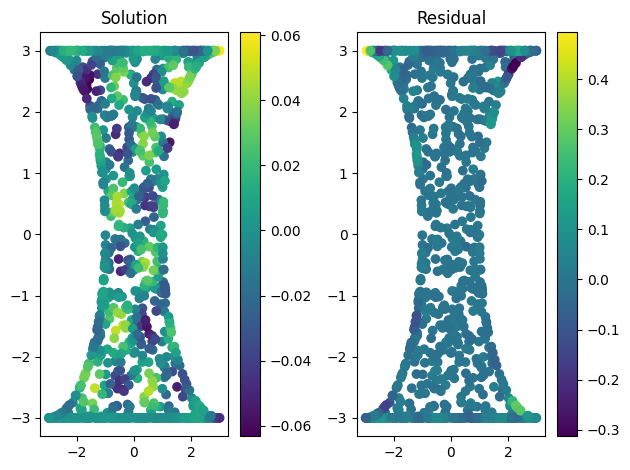

In [12]:
# sample points in the domain. remember to set requires_grad!
pts = poisson_problem.spatial_domain.sample(1000).requires_grad_(True)
# compute the solution
solution = solver(pts)
# compute the residual in the interior
equation = poisson_problem.conditions["interior"].equation
residual = solver.compute_residual(pts, equation)
# simple plot
with torch.no_grad():
    plt.subplot(1, 2, 1)
    plt.scatter(
        pts.extract("x").flatten(),
        pts.extract("y").flatten(),
        c=solution.extract("u").flatten(),
    )
    plt.colorbar()
    plt.title("Solution")
    plt.subplot(1, 2, 2)
    plt.scatter(
        pts.extract("x").flatten(),
        pts.extract("y").flatten(),
        c=residual.flatten(),
    )
    plt.colorbar()
    plt.tight_layout()
    plt.title("Residual")

## What's Next?

Congratulations on completing the introductory tutorial of **PINA**! Now that you have a solid foundation, here are a few directions you can explore:

1. **Explore Advanced Solvers**: Dive into more advanced solvers like **SAPINN** or **RBAPINN** and experiment with different variations of Physics-Informed Neural Networks.
2. **Apply PINA to New Problems**: Try solving other types of differential equations or explore inverse problems and parametric problems using the PINA framework.
3. **Optimize Model Performance**: Use the `Trainer` class to enhance model performance by exploring features like dynamic learning rates, early stopping, and model checkpoints.

4. **...and many more!** — There are countless directions to further explore, from testing on different problems to refining the model architecture!

For more resources and tutorials, check out the [PINA Documentation](https://mathlab.github.io/PINA/).


### References

[1] *Coscia, Dario, et al. "Physics-informed neural networks for advanced modeling." Journal of Open Source Software, 2023.*

[2] *Hernández-Lobato, José Miguel, and Ryan Adams. "Probabilistic backpropagation for scalable learning of bayesian neural networks." International conference on machine learning, 2015.*

[3] *Gal, Yarin, and Zoubin Ghahramani. "Dropout as a bayesian approximation: Representing model uncertainty in deep learning." International conference on machine learning, 2016.*

[4] *Raissi, Maziar, Paris Perdikaris, and George E. Karniadakis. "Physics-informed neural networks: A deep learning framework for solving forward and inverse problems involving nonlinear partial differential equations." Journal of Computational Physics, 2019.*

[5] *McClenny, Levi D., and Ulisses M. Braga-Neto. "Self-adaptive physics-informed neural networks." Journal of Computational Physics, 2023.*

[6] *Anagnostopoulos, Sokratis J., et al. "Residual-based attention in physics-informed neural networks." Computer Methods in Applied Mechanics and Engineering, 2024.*